In [1]:
!module load devel/cuda/12.4
!export CUDA_LAUNCH_BLOCKING=1


The following have been reloaded with a version change:
  1) devel/cuda/11.8 => devel/cuda/12.4



In [2]:
import os
# print(os.getcwd())
os.chdir('/pfs/data5/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/training')
# print(os.getcwd())

In [3]:
import yaml
import torch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
torch.cuda.set_device(0)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import sys
# os.environ["CUDA_VISIBLE_DEVICES"] = "" 
sys.argv = ["train.py"]
from train import init_seed, prepare_training_data, prepare_testing_data, choose_optimizer, choose_scheduler, choose_metric
import torch.backends.cudnn as cudnn
import torch.distributed as dist
from datetime import timedelta
from detectors import DETECTOR
from trainer.trainer import Trainer


def load_config(path, additional_args = {}):
    # parse options and load config
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
    try:# KAI: added this, to ensure it finds the config file
        with open('./training/config/train_config.yaml', 'r') as f:
            config2 = yaml.safe_load(f)
    except FileNotFoundError:
        with open(os.path.expanduser('~/Interpretable-Deep-Fake-Detection/training/config/train_config.yaml'), 'r') as f:
            config2 = yaml.safe_load(f)
    if 'label_dict' in config:
        config2['label_dict']=config['label_dict']
    config.update(config2)
    # config['local_rank']=args.local_rank
    if config['dry_run']:
        config['nEpochs'] = 0
        config['save_feat']=False
    for key, value in additional_args.items():
        config[key] = value
    return config


path = "./config/detector/resnet34_bcos.yaml"
additional_args = {'test_batchSize': 4}
config = load_config(path, additional_args=additional_args)

2025-02-10 12:39:21.022046: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 12:39:21.061400: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 12:39:21.061430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 12:39:21.061453: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 12:39:21.069607: I tensorflow/core/platform/cpu_feature_g

['in_channels', 'out_channels', 'kernel_size', 'stride', 'padding', 'dilation', 'groups', 'bias', 'padding_mode', 'device', 'dtype']
spatial_count=0 keep_stride_count=0


In [4]:
from test import test_epoch, test_one_dataset, test_epoch, inference
from tqdm import tqdm
import random
# init seed
# init_seed(config)

torch.manual_seed(34)
random.seed(34)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disable for strict reproducibility

# prepare the testing data loader
test_data_loaders = prepare_testing_data(config)

# prepare the model (detector)
model_class = DETECTOR[config['model_name']]
model = model_class(config)

model.cuda()#.to("cuda:0")
print(next(model.parameters()).device)

model.eval()
# testing for all test data
keys = test_data_loaders.keys()
for key in keys:
    print(key)
    data_dict = test_data_loaders[key].dataset.data_dict
    for i, data_dict in tqdm(enumerate(test_data_loaders[key]),total=len(test_data_loaders[key])):
        if i < 3:
            if 'label_spe' in data_dict:
                data_dict.pop('label_spe')  # remove the specific label
            data_dict['label'] = torch.where(data_dict['label']!=0, 1, 0)  # fix the label to 0 and 1 only
            # move data to GPU elegantly
            for key in data_dict.keys():
                if data_dict[key]!=None:
                    data_dict[key]=data_dict[key].cuda()
            # model forward without considering gradient computation
            # print(data_dict)
            with torch.no_grad():
                predictions = inference(model, data_dict)
            print(data_dict['label'])
            print(predictions['prob'])
        else:
            break

INFO:detectors.resnet34_bcos_detector:Load pretrained model successfully!


cuda:0
FaceForensics++


  0%|          | 0/5586 [00:00<?, ?it/s]

tensor([1, 1, 1, 0], device='cuda:0')


  0%|          | 3/5586 [00:11<5:49:19,  3.75s/it] 

tensor([0.5757, 0.6111, 0.5794, 0.5630], device='cuda:0')
tensor([0, 1, 1, 1], device='cuda:0')
tensor([0.5873, 0.5824, 0.6114, 0.6151], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([0.5971, 0.5734, 0.6481, 0.5909], device='cuda:0')


## Heatmaps

INFO:detectors.resnet34_bcos_detector:Load pretrained model successfully!


cpu
FaceForensics++
dict_keys(['image', 'label', 'landmark', 'mask'])
Batch of images shape: torch.Size([2, 6, 224, 224])
torch.Size([1, 6, 224, 224])
R tensor([[-0.3098, -0.3098, -0.3098,  ..., -0.5373, -0.5451, -0.5451],
        [-0.3098, -0.3098, -0.3020,  ..., -0.5216, -0.5373, -0.5451],
        [-0.3098, -0.3020, -0.3020,  ..., -0.5137, -0.5373, -0.5373],
        ...,
        [ 0.6549,  0.6706,  0.6784,  ...,  0.5686,  0.5686,  0.5608],
        [ 0.6863,  0.6784,  0.6784,  ...,  0.5451,  0.5529,  0.5529],
        [ 0.6784,  0.7020,  0.6863,  ...,  0.5608,  0.5451,  0.5451]],
       grad_fn=<SliceBackward0>)
torch.Size([6, 224, 224])


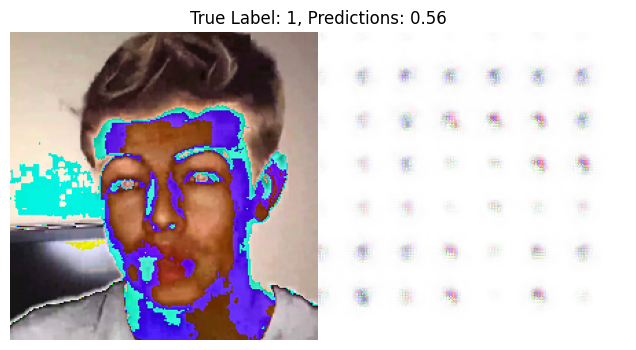

torch.Size([1, 6, 224, 224])
R tensor([[-0.6157, -0.6157, -0.5922,  ...,  0.5529,  0.5608,  0.5608],
        [-0.6235, -0.6157, -0.5922,  ...,  0.5529,  0.5608,  0.5608],
        [-0.6314, -0.6157, -0.6000,  ...,  0.5529,  0.5608,  0.5608],
        ...,
        [-0.5059, -0.4980, -0.4980,  ..., -0.3961, -0.3882, -0.3961],
        [-0.5216, -0.5137, -0.5216,  ..., -0.4039, -0.4118, -0.4039],
        [-0.5451, -0.5451, -0.5529,  ..., -0.4196, -0.4039, -0.4118]],
       grad_fn=<SliceBackward0>)
torch.Size([6, 224, 224])


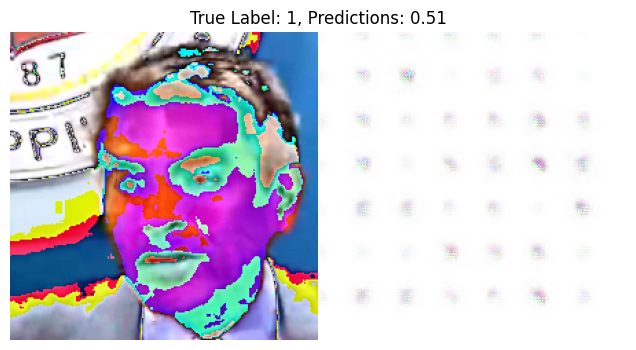

dict_keys(['image', 'label', 'landmark', 'mask'])
Batch of images shape: torch.Size([2, 6, 224, 224])
torch.Size([1, 6, 224, 224])
R tensor([[-0.8275, -0.8275, -0.8353,  ..., -0.6078, -0.6314, -0.6784],
        [-0.8275, -0.8275, -0.8353,  ..., -0.6078, -0.6314, -0.6784],
        [-0.8275, -0.8275, -0.8353,  ..., -0.6078, -0.6314, -0.6784],
        ...,
        [-0.1137, -0.0824, -0.0745,  ..., -0.7098, -0.6627, -0.6235],
        [-0.1608, -0.1137, -0.1137,  ..., -0.7255, -0.6863, -0.6392],
        [-0.3804, -0.3569, -0.3647,  ..., -0.7569, -0.7098, -0.6706]],
       grad_fn=<SliceBackward0>)
torch.Size([6, 224, 224])


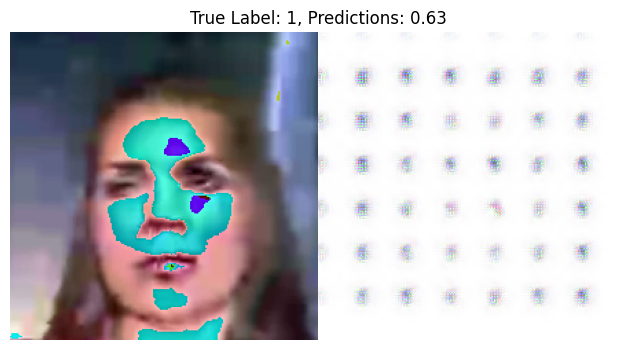

torch.Size([1, 6, 224, 224])
R tensor([[-0.3804, -0.3804, -0.3804,  ..., -0.8353, -0.8353, -0.8353],
        [-0.3804, -0.3804, -0.3804,  ..., -0.8275, -0.8275, -0.8275],
        [-0.3804, -0.3804, -0.3804,  ..., -0.8275, -0.8275, -0.8275],
        ...,
        [-0.2941, -0.2627, -0.2392,  ..., -0.1137, -0.1137, -0.1216],
        [-0.1373, -0.1686, -0.2000,  ..., -0.1137, -0.1137, -0.1137],
        [-0.0588, -0.0745, -0.1294,  ..., -0.1059, -0.0980, -0.0980]],
       grad_fn=<SliceBackward0>)
torch.Size([6, 224, 224])


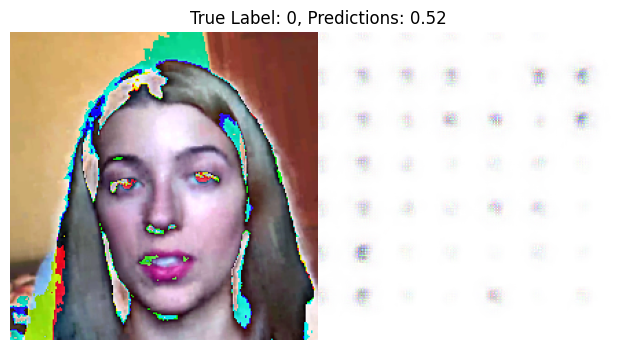

dict_keys(['image', 'label', 'landmark', 'mask'])
Batch of images shape: torch.Size([2, 6, 224, 224])
torch.Size([1, 6, 224, 224])
R tensor([[ 0.5922,  0.5922,  0.5922,  ...,  0.4118,  0.4118,  0.4118],
        [ 0.5843,  0.5843,  0.5843,  ...,  0.4118,  0.4118,  0.4118],
        [ 0.5843,  0.5843,  0.5843,  ...,  0.4118,  0.4118,  0.4118],
        ...,
        [-0.6078, -0.6235, -0.6392,  ..., -0.5608, -0.5608, -0.5608],
        [-0.6157, -0.6314, -0.6314,  ..., -0.5608, -0.5608, -0.5608],
        [-0.6078, -0.6235, -0.6235,  ..., -0.5686, -0.5686, -0.5686]],
       grad_fn=<SliceBackward0>)
torch.Size([6, 224, 224])


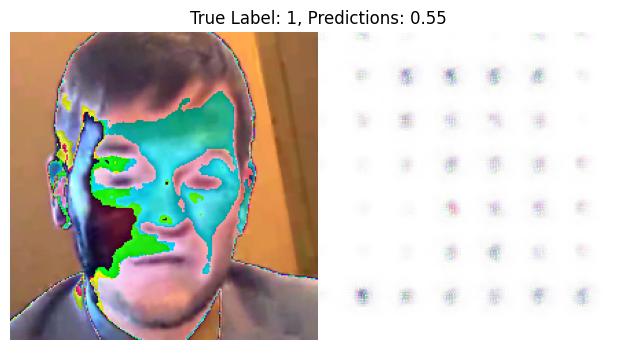

torch.Size([1, 6, 224, 224])
R tensor([[-0.4745, -0.4745, -0.4745,  ..., -0.1686, -0.1686, -0.1608],
        [-0.4745, -0.4745, -0.4745,  ..., -0.1686, -0.1686, -0.1608],
        [-0.4824, -0.4824, -0.4824,  ..., -0.1686, -0.1608, -0.1529],
        ...,
        [-0.7412, -0.7412, -0.7412,  ..., -0.6941, -0.6941, -0.6941],
        [-0.7412, -0.7412, -0.7412,  ..., -0.6941, -0.6941, -0.6941],
        [-0.7412, -0.7412, -0.7412,  ..., -0.6941, -0.6941, -0.6941]],
       grad_fn=<SliceBackward0>)
torch.Size([6, 224, 224])


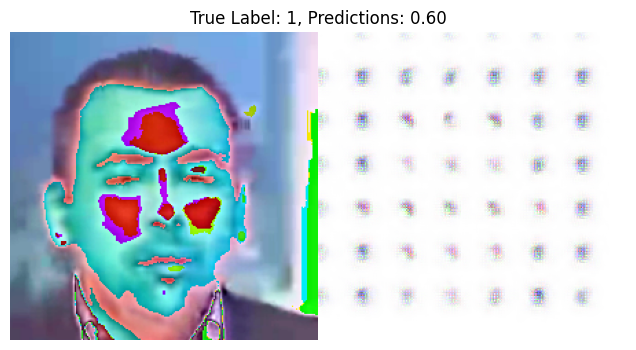

In [22]:
from bcos.interpretability import grad_to_img, to_numpy
import numpy as np
import matplotlib.pyplot as plt
from test import test_epoch, test_one_dataset, test_epoch, inference
from tqdm import tqdm
import random
# init seed
# init_seed(config)

torch.manual_seed(2)
random.seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disable for strict reproducibility

device = torch.device("cpu")

# prepare the training data loader
# train_data_loader = prepare_training_data(config)
config['test_batchSize'] = 2
# prepare the testing data loader
test_data_loaders = prepare_testing_data(config, mode="test")

# prepare the model (detector)
model_class = DETECTOR[config['model_name']]
model = model_class(config)

model.to(device)#.cuda()
print(next(model.parameters()).device)
# testing for all test data
key = list(test_data_loaders.keys())[0]
print(key)
for i, data_dict in enumerate(test_data_loaders[key]):#img_batch, label_batch in dataloader:
    if i<3:
        print(data_dict.keys())
        img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])

        print(f"Batch of images shape: {img_batch.shape}")
        # device = "cpu"
        if 'label_spe' in data_dict:
            data_dict.pop('label_spe')  # remove the specific label
        data_dict['label'] = torch.where(data_dict['label']!=0, 1, 0)  # fix the label to 0 and 1 only
        # move data to GPU elegantly
        for key in data_dict.keys():
            if data_dict[key]!=None:
                data_dict[key]=data_dict[key].to(device)#cuda()

        num_batches = img_batch.shape[0]
        # Iterate through each image in the batch
        for i in range(num_batches):
            img = img_batch[i].unsqueeze(0).to(device)#).cuda()  # Process a single image
            label = label_batch[i]
    
            img = img.requires_grad_(True)
    
            # Zero the gradients
            model.zero_grad()
    
            single_data_dict = {'image':img, 'label':label}
            # Forward pass
            features = model.features(single_data_dict)
            # get the prediction by classifier
            out = model.classifier(features)

            # we have to select a target class for which we compute the gradients 
            # -> simply choose the first one, as it represents the probability that a image is a deepfake
            prob = torch.softmax(out, dim=0)[1]
            out = out[1]
            # Backward pass
            out.backward()
    
            # Generate attention visualization
            att = grad_to_img(img[0], img.grad[0], alpha_percentile=100, smooth=5)
            att[..., -1] *= to_numpy(out.sigmoid())
    
            # Prepare the image and attention map for visualization
            att = to_numpy(att)
            print(img.shape)
            print("R", img[0, 1, :, :])
            print(img[0].shape)
            # print(img[1].shape)
            # print(img[2].shape)
            img_np = np.array(to_numpy(img[0, [0, 1, 2]].permute(1, 2, 0)) * 255, dtype=np.uint8)
    
            # Plot the results
            fig, ax = plt.subplots(1, figsize=(8, 4))
            plt.imshow(img_np, extent=(0, config['resolution'], 0, config['resolution']))
            plt.imshow(att, extent=(config['resolution'], 2 * config['resolution'], 0, config['resolution']))
            plt.xlim(0, 2 * config['resolution'])
            plt.xticks([])
            plt.yticks([])
            plt.title(f"True Label: {label}, Predictions: {out.sigmoid().item():.2f}")
            for spine in ax.spines.values():
                spine.set_visible(False)
    
            plt.show()
    else:
        break  # Exit after processing the first batches


In [21]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set model to evaluation mode
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    key = list(test_data_loaders.keys())[0]
    # print(key)
    prediction_lists = []
    feature_lists = []
    label_lists = []
    for i, data_dict in tqdm(enumerate(test_data_loaders[key]), total=len(test_data_loaders[key])):#img_batch, label_batch in dataloader:
        img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])

        # print(f"Batch of images shape: {img_batch.shape}")
        # device = "cpu"
        if 'label_spe' in data_dict:
            data_dict.pop('label_spe')  # remove the specific label
        data_dict['label'] = torch.where(data_dict['label']!=0, 1, 0)  # fix the label to 0 and 1 only
        # move data to GPU elegantly
        for key in data_dict.keys():
            if data_dict[key]!=None:
                data_dict[key]=data_dict[key].to(device)#cuda()


        predictions = inference(model, data_dict)
        cls, prob, feat = (predictions[k] for k in ['cls', 'prob', 'feat'])
        
        label_lists += list(data_dict['label'].cpu().detach().numpy())
        prediction_lists += list(predictions['prob'].cpu().detach().numpy())
        feature_lists += list(predictions['feat'].cpu().detach().numpy())

    # print(prediction_lists)
    y_pred = np.array(prediction_lists)
    threshold = 0.5
    y_pred = (y_pred >= threshold).astype(int)
    y_true = np.array(label_lists)
    # print(y_true)

100%|██████████| 11171/11171 [04:28<00:00, 41.67it/s]


In [51]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')

# Detailed classification report
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))
print(confusion_matrix(y_true, y_pred))

Test Accuracy: 0.80
              precision    recall  f1-score   support

        Real       0.18      0.01      0.01      4478
        Fake       0.80      0.99      0.89     17864

    accuracy                           0.80     22342
   macro avg       0.49      0.50      0.45     22342
weighted avg       0.68      0.80      0.71     22342

[[   29  4449]
 [  128 17736]]


# XCeption net

In [29]:
path = "./config/detector/xception.yaml"

weights_base_path = '/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/xception/logs/'
additional_args = {'test_batchSize': 12, 
                   'pretrained':
                    f'{weights_base_path}xception_2025-02-06-20-05-09/test/avg/ckpt_best.pth'
                    #f'{weights_base_path}xception_2025-02-07-10-17-17/test/avg/ckpt_best.pth'
                    #f'{weights_base_path}xception_2025-02-07-12-19-31/test/avg/ckpt_best.pth'
                    #f'{weights_base_path}xception_2025-02-07-17-23-41/test/avg/ckpt_best.pth'
                    #f'{weights_base_path}xception_2025-02-07-21-26-03/test/avg/ckpt_best.pth'
                    #f'{weights_base_path}xception_2025-02-07-21-43-33/test/avg/ckpt_best.pth'
                    #f'{weights_base_path}xception_2025-02-08-09-13-00/test/avg/ckpt_best.pth'
                  }
config = load_config(path, additional_args=additional_args)

In [30]:
from test import test_epoch, test_one_dataset, test_epoch, inference
from tqdm import tqdm
import random
# init seed
# init_seed(config)

torch.manual_seed(34)
random.seed(34)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disable for strict reproducibility

# prepare the testing data loader
test_data_loaders = prepare_testing_data(config)

# prepare the model (detector)
model_class = DETECTOR[config['model_name']]
model = model_class(config)

model.cuda()#.to("cuda:0")
print(next(model.parameters()).device)

model.eval()
# testing for all test data
keys = test_data_loaders.keys()
for key in keys:
    print(key)
    data_dict = test_data_loaders[key].dataset.data_dict
    for i, data_dict in tqdm(enumerate(test_data_loaders[key]),total=len(test_data_loaders[key])):
        if i < 3:
            if 'label_spe' in data_dict:
                data_dict.pop('label_spe')  # remove the specific label
            data_dict['label'] = torch.where(data_dict['label']!=0, 1, 0)  # fix the label to 0 and 1 only
            # move data to GPU elegantly
            for key in data_dict.keys():
                if data_dict[key]!=None:
                    data_dict[key]=data_dict[key].cuda()
            # model forward without considering gradient computation
            # print(data_dict)
            with torch.no_grad():
                predictions = inference(model, data_dict)
            print(data_dict['label'])
            print(predictions['prob'])
        else:
            break

INFO:detectors.xception_detector:Load pretrained model successfully!


cuda:0
FaceForensics++


  0%|          | 3/1862 [00:00<02:39, 11.68it/s]

tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0.5063, 0.5062, 0.5062, 0.5062, 0.5062, 0.5062, 0.5062, 0.5062, 0.5062,
        0.5062, 0.5062, 0.5062], device='cuda:0')
tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
tensor([0.5062, 0.5062, 0.5062, 0.5062, 0.5062, 0.5062, 0.5062, 0.5063, 0.5062,
        0.5063, 0.5062, 0.5062], device='cuda:0')
tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
tensor([0.5062, 0.5062, 0.5062, 0.5062, 0.5062, 0.5062, 0.5062, 0.5062, 0.5062,
        0.5062, 0.5062, 0.5062], device='cuda:0')


In [31]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set model to evaluation mode
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    key = list(test_data_loaders.keys())[0]
    # print(key)
    prediction_lists = []
    feature_lists = []
    label_lists = []
    for i, data_dict in tqdm(enumerate(test_data_loaders[key]), total=len(test_data_loaders[key])):#img_batch, label_batch in dataloader:
        img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])

        # print(f"Batch of images shape: {img_batch.shape}")
        # device = "cpu"
        if 'label_spe' in data_dict:
            data_dict.pop('label_spe')  # remove the specific label
        data_dict['label'] = torch.where(data_dict['label']!=0, 1, 0)  # fix the label to 0 and 1 only
        # move data to GPU elegantly
        for key in data_dict.keys():
            if data_dict[key]!=None:
                data_dict[key]=data_dict[key].to(device)#cuda()


        predictions = inference(model, data_dict)
        cls, prob, feat = (predictions[k] for k in ['cls', 'prob', 'feat'])
        
        label_lists += list(data_dict['label'].cpu().detach().numpy())
        prediction_lists += list(predictions['prob'].cpu().detach().numpy())
        feature_lists += list(predictions['feat'].cpu().detach().numpy())

    # print(prediction_lists)
    y_pred = np.array(prediction_lists)
    threshold = 0.5
    y_pred = (y_pred >= threshold).astype(int)
    y_true = np.array(label_lists)
    # print(y_true)

100%|██████████| 1862/1862 [01:14<00:00, 24.97it/s]


In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')

# Detailed classification report
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))
print(confusion_matrix(y_true, y_pred))

Test Accuracy: 0.80
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00      4478
        Fake       0.80      1.00      0.89     17864

    accuracy                           0.80     22342
   macro avg       0.40      0.50      0.44     22342
weighted avg       0.64      0.80      0.71     22342

[[    0  4478]
 [    0 17864]]


# Evaluating multiple model runs

## BCOS RESNET

In [ ]:
# check performance of all model runs
weights_base_path = '/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/resnet_from_scratch_runs/logs/'
runs = [f'{weights_base_path}resnet34_bcos_2025-02-05-14-05-08/test/avg/ckpt_best.pth',
        f'{weights_base_path}resnet34_bcos_2025-02-05-16-31-48/test/avg/ckpt_best.pth',
        f'{weights_base_path}resnet34_bcos_2025-02-05-18-32-54/test/avg/ckpt_best.pth',
        f'{weights_base_path}resnet34_bcos_2025-02-06-19-46-26/test/avg/ckpt_best.pth',
        f'{weights_base_path}resnet34_bcos_2025-02-07-09-30-34/test/avg/ckpt_best.pth',
        f'{weights_base_path}resnet34_bcos_2025-02-07-12-02-12/test/avg/ckpt_best.pth',
        f'{weights_base_path}resnet34_bcos_2025-02-07-17-02-26/test/avg/ckpt_best.pth',
        f'{weights_base_path}resnet34_bcos_2025-02-07-21-26-03/test/avg/ckpt_best.pth',
        f'{weights_base_path}resnet34_bcos_2025-02-08-09-15-43/test/avg/ckpt_best.pth']              

for model_run in runs:
    path = "./config/detector/resnet34_bcos.yaml"
    
    additional_args = {'test_batchSize': 12, 
                       'pretrained':model_run}
    config = load_config(path, additional_args=additional_args)
    test_data_loaders = prepare_testing_data(config)

    # prepare the model (detector)
    model_class = DETECTOR[config['model_name']]
    model = model_class(config)
    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Lists to store all predictions and true labels
    all_preds = []
    all_labels = []
    
    # Disable gradient calculation
    with torch.no_grad():
        key = list(test_data_loaders.keys())[0]
        # print(key)
        prediction_lists = []
        feature_lists = []
        label_lists = []
        for i, data_dict in tqdm(enumerate(test_data_loaders[key]), total=len(test_data_loaders[key])):#img_batch, label_batch in dataloader:
            img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])
    
            # print(f"Batch of images shape: {img_batch.shape}")
            # device = "cpu"
            if 'label_spe' in data_dict:
                data_dict.pop('label_spe')  # remove the specific label
            data_dict['label'] = torch.where(data_dict['label']!=0, 1, 0)  # fix the label to 0 and 1 only
            # move data to GPU elegantly
            for key in data_dict.keys():
                if data_dict[key]!=None:
                    data_dict[key]=data_dict[key].to(device)#cuda()
    
    
            predictions = inference(model, data_dict)
            cls, prob, feat = (predictions[k] for k in ['cls', 'prob', 'feat'])
            
            label_lists += list(data_dict['label'].cpu().detach().numpy())
            prediction_lists += list(predictions['prob'].cpu().detach().numpy())
            feature_lists += list(predictions['feat'].cpu().detach().numpy())
    
        # print(prediction_lists)
        y_pred = np.array(prediction_lists)
        threshold = 0.5
        y_pred = (y_pred >= threshold).astype(int)
        y_true = np.array(label_lists)
        # print(y_true)
        print(model_run)
        # Calculate and print the accuracy
        accuracy = accuracy_score(y_true, y_pred)
        print(f'Test Accuracy: {accuracy:.2f}')
        
        # Detailed classification report
        print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))
        print(confusion_matrix(y_true, y_pred))
        

INFO:detectors.resnet34_bcos_detector:Load pretrained model successfully!
  0%|          | 0/1862 [00:00<?, ?it/s]

## Xception

In [35]:
# check performance of all model runs
weights_base_path = '/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/xception/logs/'
runs = [f'{weights_base_path}xception_2025-02-06-20-05-09/test/avg/ckpt_best.pth',
        f'{weights_base_path}xception_2025-02-07-10-17-17/test/avg/ckpt_best.pth',
        f'{weights_base_path}xception_2025-02-07-12-19-31/test/avg/ckpt_best.pth',
        f'{weights_base_path}xception_2025-02-07-17-23-41/test/avg/ckpt_best.pth',
        f'{weights_base_path}xception_2025-02-07-21-26-03/test/avg/ckpt_best.pth',
        f'{weights_base_path}xception_2025-02-07-21-43-33/test/avg/ckpt_best.pth',
        f'{weights_base_path}xception_2025-02-08-09-13-00/test/avg/ckpt_best.pth']
                      

for model_run in runs:
    path = "./config/detector/xception.yaml"
    
    additional_args = {'test_batchSize': 12, 
                       'pretrained':model_run}
    config = load_config(path, additional_args=additional_args)

    test_data_loaders = prepare_testing_data(config)

    # prepare the model (detector)
    model_class = DETECTOR[config['model_name']]
    model = model_class(config)

    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Lists to store all predictions and true labels
    all_preds = []
    all_labels = []
    
    # Disable gradient calculation
    with torch.no_grad():
        key = list(test_data_loaders.keys())[0]
        # print(key)
        prediction_lists = []
        feature_lists = []
        label_lists = []
        for i, data_dict in tqdm(enumerate(test_data_loaders[key]), total=len(test_data_loaders[key])):#img_batch, label_batch in dataloader:
            img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])
    
            # print(f"Batch of images shape: {img_batch.shape}")
            # device = "cpu"
            if 'label_spe' in data_dict:
                data_dict.pop('label_spe')  # remove the specific label
            data_dict['label'] = torch.where(data_dict['label']!=0, 1, 0)  # fix the label to 0 and 1 only
            # move data to GPU elegantly
            for key in data_dict.keys():
                if data_dict[key]!=None:
                    data_dict[key]=data_dict[key].to(device)#cuda()
    
    
            predictions = inference(model, data_dict)
            cls, prob, feat = (predictions[k] for k in ['cls', 'prob', 'feat'])
            
            label_lists += list(data_dict['label'].cpu().detach().numpy())
            prediction_lists += list(predictions['prob'].cpu().detach().numpy())
            feature_lists += list(predictions['feat'].cpu().detach().numpy())
    
        # print(prediction_lists)
        y_pred = np.array(prediction_lists)
        threshold = 0.5
        y_pred = (y_pred >= threshold).astype(int)
        y_true = np.array(label_lists)
        # print(y_true)
        print(model_run)
        # Calculate and print the accuracy
        accuracy = accuracy_score(y_true, y_pred)
        print(f'Test Accuracy: {accuracy:.2f}')
        
        # Detailed classification report
        print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))
        print(confusion_matrix(y_true, y_pred))
        

INFO:detectors.xception_detector:Load pretrained model successfully!
100%|██████████| 1862/1862 [01:14<00:00, 24.98it/s]


/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/xception/logs/xception_2025-02-06-20-05-09/test/avg/ckpt_best.pth
Test Accuracy: 0.20
              precision    recall  f1-score   support

        Real       0.20      1.00      0.33      4478
        Fake       0.00      0.00      0.00     17864

    accuracy                           0.20     22342
   macro avg       0.10      0.50      0.17     22342
weighted avg       0.04      0.20      0.07     22342

[[ 4478     0]
 [17864     0]]


INFO:detectors.xception_detector:Load pretrained model successfully!
100%|██████████| 1862/1862 [01:14<00:00, 24.97it/s]


/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/xception/logs/xception_2025-02-07-10-17-17/test/avg/ckpt_best.pth
Test Accuracy: 0.20
              precision    recall  f1-score   support

        Real       0.20      1.00      0.33      4478
        Fake       0.00      0.00      0.00     17864

    accuracy                           0.20     22342
   macro avg       0.10      0.50      0.17     22342
weighted avg       0.04      0.20      0.07     22342

[[ 4478     0]
 [17864     0]]


INFO:detectors.xception_detector:Load pretrained model successfully!
100%|██████████| 1862/1862 [01:14<00:00, 24.94it/s]


/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/xception/logs/xception_2025-02-07-12-19-31/test/avg/ckpt_best.pth
Test Accuracy: 0.80
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00      4478
        Fake       0.80      1.00      0.89     17864

    accuracy                           0.80     22342
   macro avg       0.40      0.50      0.44     22342
weighted avg       0.64      0.80      0.71     22342

[[    0  4478]
 [    0 17864]]


INFO:detectors.xception_detector:Load pretrained model successfully!
100%|██████████| 1862/1862 [01:14<00:00, 25.02it/s]


/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/xception/logs/xception_2025-02-07-17-23-41/test/avg/ckpt_best.pth
Test Accuracy: 0.20
              precision    recall  f1-score   support

        Real       0.20      1.00      0.33      4478
        Fake       0.00      0.00      0.00     17864

    accuracy                           0.20     22342
   macro avg       0.10      0.50      0.17     22342
weighted avg       0.04      0.20      0.07     22342

[[ 4478     0]
 [17864     0]]


INFO:detectors.xception_detector:Load pretrained model successfully!
100%|██████████| 1862/1862 [01:14<00:00, 24.89it/s]


/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/xception/logs/xception_2025-02-07-21-26-03/test/avg/ckpt_best.pth
Test Accuracy: 0.80
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00      4478
        Fake       0.80      1.00      0.89     17864

    accuracy                           0.80     22342
   macro avg       0.40      0.50      0.44     22342
weighted avg       0.64      0.80      0.71     22342

[[    0  4478]
 [    0 17864]]


INFO:detectors.xception_detector:Load pretrained model successfully!
100%|██████████| 1862/1862 [01:14<00:00, 24.91it/s]


/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/xception/logs/xception_2025-02-07-21-43-33/test/avg/ckpt_best.pth
Test Accuracy: 0.80
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00      4478
        Fake       0.80      1.00      0.89     17864

    accuracy                           0.80     22342
   macro avg       0.40      0.50      0.44     22342
weighted avg       0.64      0.80      0.71     22342

[[    0  4478]
 [    0 17864]]


INFO:detectors.xception_detector:Load pretrained model successfully!
100%|██████████| 1862/1862 [01:14<00:00, 24.90it/s]

/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/xception/logs/xception_2025-02-08-09-13-00/test/avg/ckpt_best.pth
Test Accuracy: 0.20
              precision    recall  f1-score   support

        Real       0.20      1.00      0.33      4478
        Fake       0.00      0.00      0.00     17864

    accuracy                           0.20     22342
   macro avg       0.10      0.50      0.17     22342
weighted avg       0.04      0.20      0.07     22342

[[ 4478     0]
 [17864     0]]
